# Github repo url

[https://github.com/SkyDocs/Plant-Disease-Detection](https://github.com/SkyDocs/Plant-Disease-Detection)

In [1]:
import os

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch.optim as optim
import matplotlib.pyplot as plt
import pickle


In [67]:
torch.cuda.is_available()

True

In [68]:
#!unzip dataset.zip

dataset classification

In [2]:
class trainData():
    def __init__(self):
        self.labels,self.images = self.load_data()
    
    def load_data(self):
        labels={}
        images = {}
        count = 0
        
        resize = transforms.Compose([transforms.Resize((256,256))])
        main_dir = os.listdir(os.path.join("dataset","train"))
        reference = {}
        
        for i,dir in enumerate(main_dir):
            reference[dir]=i
            images_list = os.listdir(os.path.join("dataset","train",dir))
            local_cnt = 0
            
            for img in images_list:
                if local_cnt<500:
                    labels[count] = i
                    img_path = os.path.join("dataset","train",dir,img)
                    image = Image.open(img_path)
                    image = ToTensor()(image)
                    images[count] = resize(image)
                    count+=1
                    local_cnt+=1
                else:
                    break

        print(reference)
        return labels,images
      
    def __len__(self):
        return len(self.labels)
    

    # To return x,y values in each iteration over dataloader as batches.
    def __getitem__(self, idx):
        return (
            self.images[idx],
            self.labels[idx],
        )

In [3]:
train_data = trainData()

{'Cherry___Powdery_mildew': 0, 'Pepper___Bacterial_spot': 1, 'Tomato___healthy': 2, 'Potato___healthy': 3, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 4, 'Cherry___healthy': 5, 'Tomato___Leaf_Mold': 6, 'Tomato___Septoria_leaf_spot': 7, 'Tomato___Late_blight': 8, 'Tomato___Tomato_mosaic_virus': 9, 'Tomato___Bacterial_spot': 10, 'Tomato___Target_Spot': 11, 'Pepper___healthy': 12, 'Tomato___Early_blight': 13, 'Potato___Early_blight': 14, 'Tomato___Spider_mites Two-spotted_spider_mite': 15, 'Potato___Late_blight': 16}


In [4]:
class validationData(trainData):

    def load_data(self):
          labels={}
          images = {}
          count = 0
          resize = transforms.Compose([transforms.Resize((256,256))])
          main_dir = os.listdir(os.path.join("dataset","valid"))
          for i,dir in enumerate(main_dir):
              print(i,dir)
              images_list = os.listdir(os.path.join("dataset","valid",dir))
              local_cnt = 0
              for img in images_list:
                  if(local_cnt<100):
                      labels[count] = i
                      img_path = os.path.join("dataset","valid",dir,img)
                      image = Image.open(img_path)
                      image = ToTensor()(image)
                      images[count] = resize(image)
                      count+=1
                      local_cnt+=1
                  else:
                      break

          return labels,images

In [5]:
valid_data = validationData()

0 Cherry___Powdery_mildew
1 Pepper___Bacterial_spot
2 Tomato___healthy
3 Potato___healthy
4 Tomato___Tomato_Yellow_Leaf_Curl_Virus
5 Cherry___healthy
6 Tomato___Leaf_Mold
7 Tomato___Septoria_leaf_spot
8 Tomato___Late_blight
9 Tomato___Tomato_mosaic_virus
10 Tomato___Bacterial_spot
11 Tomato___Target_Spot
12 Pepper___healthy
13 Tomato___Early_blight
14 Potato___Early_blight
15 Tomato___Spider_mites Two-spotted_spider_mite
16 Potato___Late_blight


In [6]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

model

In [7]:
class neuralNet(nn.Module):
    def __init__(self):
        super(neuralNet,self).__init__()

        self.conv1= nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5)
        self.conv2= nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)
        self.conv3= nn.Conv2d(in_channels=12,out_channels=24,kernel_size=5)
        self.conv4= nn.Conv2d(in_channels=24,out_channels=48,kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=48*12*12,out_features=240)
        self.fc2 = nn.Linear(in_features=240,out_features=120)
        self.out = nn.Linear(in_features=120,out_features=17)
        
        
    def forward(self,t):
        t = t
        
        t=self.conv1(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)
        
        
        t=self.conv2(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)

        t=self.conv3(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)

        t=self.conv4(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)
        
        t=t.reshape(-1,48*12*12)
        t=self.fc1(t)
        t=F.relu(t)
        
        
        t=self.fc2(t)
        t=F.relu(t)
        
        t=self.out(t)
        
        
        return t

In [8]:
model = neuralNet()

training

In [9]:
def train(train_data,valid_data, model):
    model.train()

    
    dataloader = torch.utils.data.DataLoader(train_data, batch_size=64,shuffle=True)
    valdataloader = torch.utils.data.DataLoader(valid_data, batch_size=32,shuffle=True)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_of_epochs = 10
    epochs = []
    losses = []
    for epoch in range(num_of_epochs):
        cnt = 0
        tot_loss = 0
        tot_correct = 0
        for batch, (x, y) in enumerate(dataloader):
            
            optimizer.zero_grad()
            y_pred = model(x)
            
            loss = F.cross_entropy(y_pred,y)

            loss.backward()
            optimizer.step()

        for batch, (x, y) in enumerate(valdataloader):
            optimizer.zero_grad()
            with torch.no_grad():
                y_pred = model(x)
                loss = F.cross_entropy(y_pred,y)

            tot_loss += loss.item()
            tot_correct += get_num_correct(y_pred,y)
        epochs.append(epoch)
        losses.append(tot_loss)
        print("Epoch",epoch,"total_correct",tot_correct,"loss:",tot_loss)
        torch.save(model.state_dict(), "model002_ep"+str(epoch+1)+".pth")
        
        plt.plot(epochs, losses, color='green', linewidth = 3, marker='o', markerfacecolor='blue', markersize=8) 
        plt.xlabel('epochs ---->',color='m',fontsize='x-large' ) 
        plt.ylabel('loss ------>',color='m',fontsize='x-large') 
        axes = plt.gca()
        axes.set_facecolor('c')
        axes.tick_params(axis='y', which='both', colors='tomato')
        axes.tick_params(axis='x', which='both', colors='#20ff14')
        plt.title("Val Loss vs Epoch",color='m',fontsize='x-large')

Epoch 0 total_correct 13 loss: 16.992804765701294
Epoch 1 total_correct 24 loss: 16.353777408599854
Epoch 2 total_correct 26 loss: 15.921118259429932
Epoch 3 total_correct 39 loss: 14.237004518508911
Epoch 4 total_correct 43 loss: 13.733189105987549
Epoch 5 total_correct 50 loss: 12.62095308303833
Epoch 6 total_correct 49 loss: 12.546177625656128
Epoch 7 total_correct 59 loss: 11.871824502944946
Epoch 8 total_correct 74 loss: 11.168455004692078
Epoch 9 total_correct 63 loss: 11.571361184120178


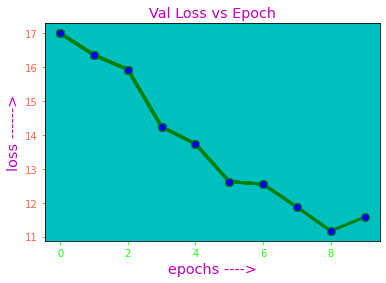

In [10]:
train(train_data, valid_data, model)

In [11]:
# Saving labels to label value as a json
main_dir = os.listdir(os.path.join("dataset","train"))
reference = {}
for i,dir in enumerate(main_dir):
    reference[dir]=i
with open('labels.json', 'wb') as iw:
    pickle.dump(reference, iw)


In [12]:
torch.save(model.state_dict(), "model.pth")

In [13]:
def train(train_data,valid_data, model):
    model.train()

    
    dataloader = torch.utils.data.DataLoader(train_data, batch_size=64,shuffle=True)
    valdataloader = torch.utils.data.DataLoader(valid_data, batch_size=32,shuffle=True)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_of_epochs = 15
    epochs = []
    losses = []
    for epoch in range(num_of_epochs):
        cnt = 0
        tot_loss = 0
        tot_correct = 0
        for batch, (x, y) in enumerate(dataloader):
            
            optimizer.zero_grad()
            y_pred = model(x)
            
            loss = F.cross_entropy(y_pred,y)

            loss.backward()
            optimizer.step()

        for batch, (x, y) in enumerate(valdataloader):
            optimizer.zero_grad()
            with torch.no_grad():
                y_pred = model(x)
                loss = F.cross_entropy(y_pred,y)

            tot_loss += loss.item()
            tot_correct += get_num_correct(y_pred,y)
        epochs.append(epoch)
        losses.append(tot_loss)
        print("Epoch",epoch,"total_correct",tot_correct,"loss:",tot_loss)
        torch.save(model.state_dict(), "model002_ep"+str(epoch+1)+".pth")
        
        plt.plot(epochs, losses, color='green', linewidth = 3, marker='o', markerfacecolor='blue', markersize=8) 
        plt.xlabel('epochs ---->',color='m',fontsize='x-large' ) 
        plt.ylabel('loss ------>',color='m',fontsize='x-large') 
        axes = plt.gca()
        axes.set_facecolor('c')
        axes.tick_params(axis='y', which='both', colors='tomato')
        axes.tick_params(axis='x', which='both', colors='#20ff14')
        plt.title("Val Loss vs Epoch",color='m',fontsize='x-large')

Epoch 0 total_correct 63 loss: 11.477211475372314
Epoch 1 total_correct 71 loss: 10.960898637771606
Epoch 2 total_correct 70 loss: 10.571221351623535
Epoch 3 total_correct 80 loss: 10.391300797462463
Epoch 4 total_correct 73 loss: 11.020711064338684
Epoch 5 total_correct 78 loss: 10.61013150215149
Epoch 6 total_correct 81 loss: 10.333676099777222
Epoch 7 total_correct 90 loss: 9.29483687877655
Epoch 8 total_correct 85 loss: 9.566183090209961
Epoch 9 total_correct 85 loss: 9.257865190505981
Epoch 10 total_correct 84 loss: 9.128125011920929
Epoch 11 total_correct 90 loss: 9.36246931552887
Epoch 12 total_correct 79 loss: 11.660540461540222
Epoch 13 total_correct 89 loss: 9.425724625587463
Epoch 14 total_correct 83 loss: 12.230554103851318


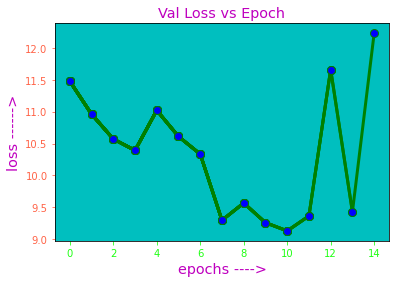

In [14]:
train(train_data, valid_data, model)

In [15]:
def train(train_data,valid_data, model):
    model.train()

    
    dataloader = torch.utils.data.DataLoader(train_data, batch_size=64,shuffle=True)
    valdataloader = torch.utils.data.DataLoader(valid_data, batch_size=32,shuffle=True)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_of_epochs = 15
    epochs = []
    losses = []
    for epoch in range(num_of_epochs):
        cnt = 0
        tot_loss = 0
        tot_correct = 0
        for batch, (x, y) in enumerate(dataloader):
            
            optimizer.zero_grad()
            y_pred = model(x)
            
            loss = F.cross_entropy(y_pred,y)

            loss.backward()
            optimizer.step()

        for batch, (x, y) in enumerate(valdataloader):
            optimizer.zero_grad()
            with torch.no_grad():
                y_pred = model(x)
                loss = F.cross_entropy(y_pred,y)

            tot_loss += loss.item()
            tot_correct += get_num_correct(y_pred,y)
        epochs.append(epoch)
        losses.append(tot_loss)
        print("Epoch",epoch,"total_correct",tot_correct,"loss:",tot_loss)
        torch.save(model.state_dict(), "model002_ep"+str(epoch+1)+".pth")
        
        plt.plot(epochs, losses, color='green', linewidth = 3, marker='o', markerfacecolor='blue', markersize=8) 
        plt.xlabel('epochs ---->',color='m',fontsize='x-large' ) 
        plt.ylabel('loss ------>',color='m',fontsize='x-large') 
        axes = plt.gca()
        axes.set_facecolor('c')
        axes.tick_params(axis='y', which='both', colors='tomato')
        axes.tick_params(axis='x', which='both', colors='#20ff14')
        plt.title("Val Loss vs Epoch",color='m',fontsize='x-large')

Epoch 0 total_correct 71 loss: 10.369080305099487
Epoch 1 total_correct 90 loss: 9.113889455795288
Epoch 2 total_correct 90 loss: 10.534162878990173
Epoch 3 total_correct 91 loss: 11.16359031200409
Epoch 4 total_correct 95 loss: 9.081087231636047
Epoch 5 total_correct 90 loss: 11.488938331604004
Epoch 6 total_correct 94 loss: 10.148410439491272
Epoch 7 total_correct 101 loss: 11.85626232624054
Epoch 8 total_correct 98 loss: 10.47363567352295
Epoch 9 total_correct 92 loss: 11.575613975524902
Epoch 10 total_correct 93 loss: 12.11383306980133
Epoch 11 total_correct 103 loss: 11.208210945129395
Epoch 12 total_correct 95 loss: 13.5606187582016
Epoch 13 total_correct 95 loss: 11.514507532119751
Epoch 14 total_correct 94 loss: 14.354549884796143


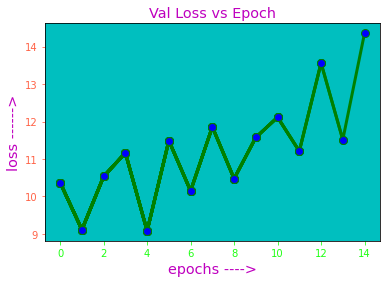

In [16]:
train(train_data, valid_data, model)

predict

In [90]:
def predict(img_path):
    image = Image.open(img_path)
    image = ToTensor()(image)
    resize = transforms.Compose([transforms.Resize((256,256))])
    y_result = model(resize(image).unsqueeze(0))
    result_idx = y_result.argmax(dim=1)
    for key,value in reference.items():
        if(value==result_idx):
            print(key)
            break

In [92]:
predict("/home/harshit/Downloads/Potato.jpg")

Potato___Early_blight
